# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


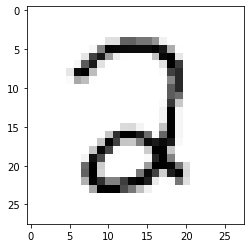

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2309
Training Accuracy: 0.7816, Testing Accuracy: 0.7727



Epoch 10, Loss 0.1056
Training Accuracy: 0.9079, Testing Accuracy: 0.9199



Epoch 20, Loss 0.0632
Training Accuracy: 0.9341, Testing Accuracy: 0.9486



Epoch 30, Loss 0.0487
Training Accuracy: 0.9459, Testing Accuracy: 0.9582



Epoch 40, Loss 0.0416
Training Accuracy: 0.9525, Testing Accuracy: 0.9677



Epoch 50, Loss 0.0373
Training Accuracy: 0.9580, Testing Accuracy: 0.9713



Epoch 60, Loss 0.0344
Training Accuracy: 0.9603, Testing Accuracy: 0.9718



Epoch 70, Loss 0.0322
Training Accuracy: 0.9629, Testing Accuracy: 0.9733



Epoch 80, Loss 0.0305
Training Accuracy: 0.9647, Testing Accuracy: 0.9728



Epoch 90, Loss 0.0292
Training Accuracy: 0.9670, Testing Accuracy: 0.9723



Epoch 100, Loss 0.028
Training Accuracy: 0.9684, Testing Accuracy: 0.9718



Epoch 110, Loss 0.0269
Training Accuracy: 0.9694, Testing Accuracy: 0.9718



Epoch 120, Loss 0.026
Training Accuracy: 0.9700, Testing Accuracy: 0.9738



Epoch 130, Loss 0.0252
Training Accuracy: 0.9711, Testing Accuracy: 0.9733



Epoch 140, Loss 0.0245
Training Accuracy: 0.9719, Testing Accuracy: 0.9738



Epoch 150, Loss 0.0238
Training Accuracy: 0.9726, Testing Accuracy: 0.9738



Epoch 160, Loss 0.0232
Training Accuracy: 0.9735, Testing Accuracy: 0.9738



Epoch 170, Loss 0.0226
Training Accuracy: 0.9739, Testing Accuracy: 0.9738



Epoch 180, Loss 0.0221
Training Accuracy: 0.9750, Testing Accuracy: 0.9753



Epoch 190, Loss 0.0216
Training Accuracy: 0.9756, Testing Accuracy: 0.9753



Epoch 200, Loss 0.0211
Training Accuracy: 0.9762, Testing Accuracy: 0.9758



Epoch 210, Loss 0.0207
Training Accuracy: 0.9768, Testing Accuracy: 0.9758



Epoch 220, Loss 0.0202
Training Accuracy: 0.9773, Testing Accuracy: 0.9758



Epoch 230, Loss 0.0198
Training Accuracy: 0.9779, Testing Accuracy: 0.9763



Epoch 240, Loss 0.0194
Training Accuracy: 0.9785, Testing Accuracy: 0.9768



0.043068642806490955

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2498
Training Accuracy: 0.6649, Testing Accuracy: 0.6578



Epoch 10, Loss 0.1063
Training Accuracy: 0.9006, Testing Accuracy: 0.9133



Epoch 20, Loss 0.0818
Training Accuracy: 0.9223, Testing Accuracy: 0.9360



Epoch 30, Loss 0.0703
Training Accuracy: 0.9306, Testing Accuracy: 0.9461



Epoch 40, Loss 0.0634
Training Accuracy: 0.9367, Testing Accuracy: 0.9491



Epoch 50, Loss 0.0586
Training Accuracy: 0.9406, Testing Accuracy: 0.9521



Epoch 60, Loss 0.0551
Training Accuracy: 0.9434, Testing Accuracy: 0.9567



Epoch 70, Loss 0.0524
Training Accuracy: 0.9454, Testing Accuracy: 0.9582



Epoch 80, Loss 0.0502
Training Accuracy: 0.9476, Testing Accuracy: 0.9602



Epoch 90, Loss 0.0485
Training Accuracy: 0.9493, Testing Accuracy: 0.9597



Epoch 100, Loss 0.047
Training Accuracy: 0.9507, Testing Accuracy: 0.9612



Epoch 110, Loss 0.0457
Training Accuracy: 0.9518, Testing Accuracy: 0.9612



Epoch 120, Loss 0.0446
Training Accuracy: 0.9534, Testing Accuracy: 0.9632



Epoch 130, Loss 0.0436
Training Accuracy: 0.9543, Testing Accuracy: 0.9637



Epoch 140, Loss 0.0427
Training Accuracy: 0.9550, Testing Accuracy: 0.9642



Epoch 150, Loss 0.0419
Training Accuracy: 0.9557, Testing Accuracy: 0.9647



Epoch 160, Loss 0.0412
Training Accuracy: 0.9566, Testing Accuracy: 0.9652



Epoch 170, Loss 0.0406
Training Accuracy: 0.9573, Testing Accuracy: 0.9657



Epoch 180, Loss 0.04
Training Accuracy: 0.9580, Testing Accuracy: 0.9662



Epoch 190, Loss 0.0394
Training Accuracy: 0.9586, Testing Accuracy: 0.9662



Epoch 200, Loss 0.0389
Training Accuracy: 0.9590, Testing Accuracy: 0.9662



Epoch 210, Loss 0.0385
Training Accuracy: 0.9598, Testing Accuracy: 0.9667



Epoch 220, Loss 0.038
Training Accuracy: 0.9604, Testing Accuracy: 0.9667



Epoch 230, Loss 0.0376
Training Accuracy: 0.9608, Testing Accuracy: 0.9667



Epoch 240, Loss 0.0373
Training Accuracy: 0.9606, Testing Accuracy: 0.9667



0.014314107361963601

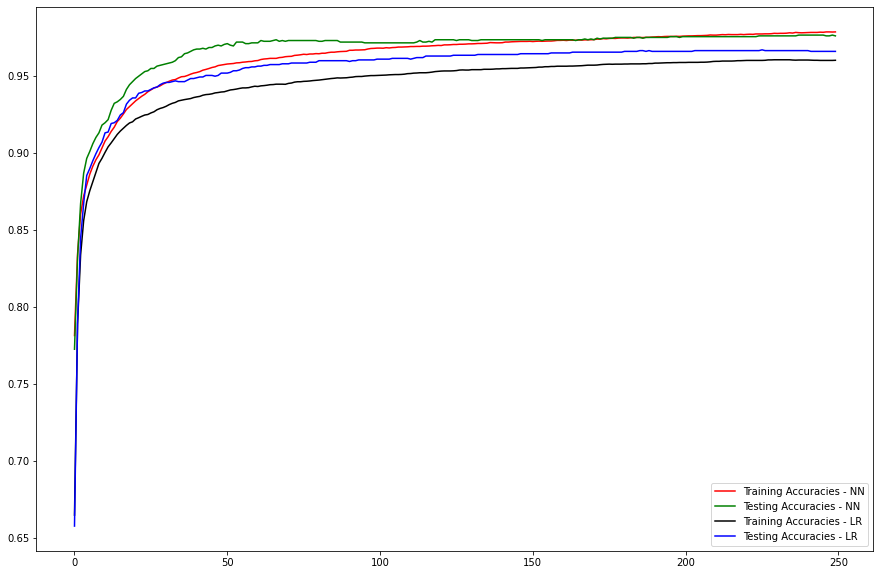

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

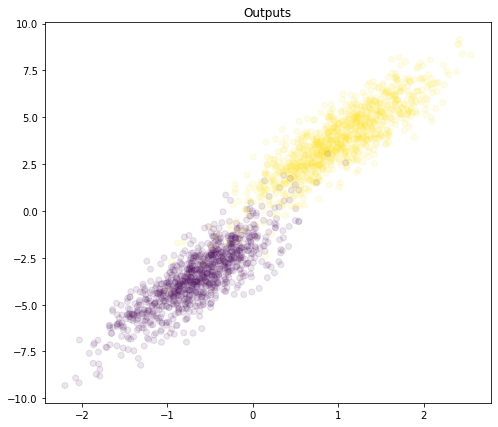

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

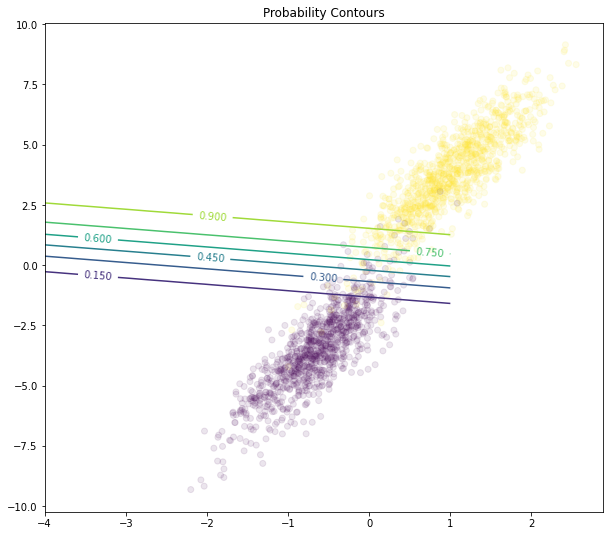

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );